# **Telco Customer Retention: Churn Prediction and Feedback Insights Using Classification and Topic Modelling**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import json
from xgboost import XGBClassifier

from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# load data
data = pd.read_csv("fix-data.csv")
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   object 
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   tenure             7032 non-null   int64  
 6   phone_service      7032 non-null   object 
 7   multiple_lines     7032 non-null   object 
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   object 
 10  streaming_tv       7032 non-null   object 
 11  contract           7032 non-null   object 
 12  paperless_billing  7032 non-null   object 
 13  payment_method     7032 non-null   object 
 14  monthly_charges    7032 non-null   float64
 15  total_charges      7032 non-null   float64
 16  churn              7032 

## I. Feature Engineering

### A. Handle Cardinality

In [3]:
# drop customer_id column because we not gonna
# use it on modelling
df_use = df.drop(columns = 'customer_id')
df_use

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
0,female,no,yes,no,1,no,no phone service,dsl,no,no,month-to-month,yes,electronic check,29.85,29.85,0,NaN
1,male,no,no,no,34,yes,no,dsl,yes,no,one year,no,mailed check,56.95,1889.50,0,NaN
2,male,no,no,no,2,yes,no,dsl,yes,no,month-to-month,yes,mailed check,53.85,108.15,1,NaN
3,male,no,no,no,45,no,no phone service,dsl,yes,no,one year,no,bank transfer (automatic),42.30,1840.75,0,NaN
4,female,no,no,no,2,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.70,151.65,1,I feel like this service could be good if they...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,female,no,no,no,1,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.10,70.10,1,NaN
7028,female,no,yes,yes,72,yes,yes,dsl,yes,yes,two year,no,credit card (automatic),89.75,6595.90,0,NaN
7029,male,yes,yes,no,60,yes,no,fiber optic,no,yes,one year,yes,electronic check,97.95,5867.00,0,"I signed up because of a promo, and the pricin..."
7030,female,no,yes,yes,11,yes,no,no,no internet service,no internet service,one year,yes,mailed check,20.00,196.35,0,NaN


In [4]:
# list of unique values

# showing maximum rows
pd.set_option('display.max_colwidth', None)

# empty list for unique value table
cat_cols = ['gender', 'senior_citizen', 'partner',
       'dependents', 'phone_service', 'multiple_lines',
       'internet_service', 'online_security', 'streaming_tv', 'contract',
       'paperless_billing', 'payment_method']

list_cardinal = []

# looping for unique values table
for col in cat_cols:
    list_cardinal.append([col, df_use[col].nunique(), df_use[col].unique()])
# displaying dataframe 
unique = pd.DataFrame(columns = ['col_name', 'total_unique_val', 'col_unique_val'], data = list_cardinal)
unique

,col_name,total_unique_val,col_unique_val
0,gender,2,"[female, male]"
1,senior_citizen,2,"[no, yes]"
2,partner,2,"[yes, no]"
3,dependents,2,"[no, yes]"
4,phone_service,2,"[no, yes]"
5,multiple_lines,3,"[no phone service, no, yes]"
6,internet_service,3,"[dsl, fiber optic, no]"
7,online_security,3,"[no, yes, no internet service]"
8,streaming_tv,3,"[no, yes, no internet service]"
9,contract,3,"[month-to-month, one year, two year]"


Explanation:

We don't need to handle cardinality since the unique values for each column are not much.

### B. Split Between Features and Target

In [5]:
# split features and target
X = df_use.drop(columns=['churn', 'customer_feedback'])
y = df_use.churn

In [6]:
# displaying features
X

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges
0,female,no,yes,no,1,no,no phone service,dsl,no,no,month-to-month,yes,electronic check,29.85,29.85
1,male,no,no,no,34,yes,no,dsl,yes,no,one year,no,mailed check,56.95,1889.50
2,male,no,no,no,2,yes,no,dsl,yes,no,month-to-month,yes,mailed check,53.85,108.15
3,male,no,no,no,45,no,no phone service,dsl,yes,no,one year,no,bank transfer (automatic),42.30,1840.75
4,female,no,no,no,2,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,female,no,no,no,1,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.10,70.10
7028,female,no,yes,yes,72,yes,yes,dsl,yes,yes,two year,no,credit card (automatic),89.75,6595.90
7029,male,yes,yes,no,60,yes,no,fiber optic,no,yes,one year,yes,electronic check,97.95,5867.00
7030,female,no,yes,yes,11,yes,no,no,no internet service,no internet service,one year,yes,mailed check,20.00,196.35


In [7]:
# displaying target
y

0       0
1       0
2       1
3       0
4       1
       ..
7027    1
7028    0
7029    0
7030    0
7031    1
Name: churn, Length: 7032, dtype: int64

### C. Split Between Train and Test Set

In [8]:
# spllit train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=45, stratify=y)

In [9]:
# train and test set 
print(f"Train set: {y_train.shape}")
print(f"Test set: {y_test.shape}")

Train set: (4219,)
Test set: (2813,)


### D. Handle Outliers

In [10]:
# looping to determine type of distribution

num_cols = ['tenure', 'monthly_charges', 'total_charges']

# empty list for outlier table
list_outlier = []

# looping for determining the outlier
for column in num_cols:
    list_outlier.append([column, round(X_train[column].skew(),1), np.where(0.5 >= X_train[column].skew() >= -0.5,
                                                                      'normal', 'skewed')])

# store it to variable and display it   
skewness = pd.DataFrame(columns = ['col_name', 'skew_value', 'distribution_type'], data = list_outlier)
skewness

,col_name,skew_value,distribution_type
0,tenure,0.3,normal
1,monthly_charges,-0.2,normal
2,total_charges,1.0,skewed


In [11]:
# empty list
columns = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  column = skewness['col_name'][row]
  # if it's have skewed distribution
  if skewness['distribution_type'][row] == 'skewed':
    IQR = X_train[column].quantile(0.75) - X_train[column].quantile(0.25)
    lower_boundary = X_train[column].quantile(0.25) - (IQR * 3)
    upper_boundary = X_train[column].quantile(0.75) + (IQR * 3)
  # if it's have normal distribution
  else:
    lower_boundary = X_train[column].mean() - 3* X_train[column].std()
    upper_boundary = X_train[column].mean() + 3* X_train[column].std()
  # append to a list
  columns.append(column)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(X_train[X_train[column] > upper_boundary]) / len(X_train) * 100) + (len(X_train[X_train[column] < lower_boundary]) / len(X_train) * 100))
  percent_total_outlier.append(totout)

# create a table for upper boundary, lower boundary, and percentage of total outlier
outliers = pd.DataFrame({
    'column': columns,
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,tenure,105.23,-41.01,0.0
1,monthly_charges,154.51,-26.07,0.0
2,total_charges,13366.88,-9333.07,0.0


Explanation:

Based on the table above, there's no outlier on the data.

### E. Check Missing Value

In [12]:
# check missing value on train and test set
print(f"Missing value on set train: {X_train.isnull().sum().sum()}")
print(f"Missing value on set test: {X_test.isnull().sum().sum()}")

Missing value on set train: 0
Missing value on set test: 0


Explanation:

There's no missing value in the data.

### F. Feature Selection

In [13]:
# checking feature importances for numerical columns

# list of numerical columns
num_cols = ['tenure', 'monthly_charges', 'total_charges']

feature_rf = RandomForestClassifier()
feature_rf.fit(X_train[num_cols], y_train)

# create dataframe for feature importances
num_selection = pd.DataFrame({
    'col_name': num_cols,
    'feature_importance': feature_rf.feature_importances_
})

num_selection

,col_name,feature_importance
0,tenure,0.223992
1,monthly_charges,0.391066
2,total_charges,0.384943


Explanation:

From the table above, we can see that all of the numerical columns have close feature importance values. It means that all of the value is important to churn prediction. Next, we will do feature selection from categorical columns.

In [14]:
# checking feature importance for categorical columns

# make a list of categorical columns
cat_cols = ['gender', 'senior_citizen', 'partner',
       'dependents', 'phone_service', 'multiple_lines',
       'internet_service', 'online_security', 'streaming_tv', 'contract',
       'paperless_billing', 'payment_method']

# create empty list for dataframe
list_col = []

# looping for correlation table
for col in cat_cols:
    corr, pval = stats.kendalltau(df_use[col], df_use['churn'])
    list_col.append([col, corr])

# displaying the table
cat_selection = pd.DataFrame(columns = ['col_name', 'corr_value'], data = list_col)
cat_selection

,col_name,corr_value
0,gender,-0.008545
1,senior_citizen,0.150541
2,partner,-0.149982
3,dependents,-0.163128
4,phone_service,0.011691
5,multiple_lines,0.036526
6,internet_service,-0.026982
7,online_security,-0.288289
8,streaming_tv,-0.035627
9,contract,-0.386437


Explanation:

Based on the correlation above, we can see that gender, phone_service, multiple_lines, internet_service, and streaming_tv have very weak influences on prediction. We can use other columns, other than those 5 columns to train the models.

### G. Data Balancing

In [15]:
# check balance of the data
unbalanced_data = y_train.value_counts().reset_index()

# calculate percentage
unbalanced_data['percentage'] = (unbalanced_data['count']/unbalanced_data['count'].sum()) * 100

# display table
unbalanced_data

,churn,count,percentage
0,0,3098,73.429723
1,1,1121,26.570277


Explanation:

The proportion of the minority class in the data is 26.45%. We can conclude that this data has a mild imbalance between classes. We gonna do a data-balancing process to balance the classes.

In [16]:
X_train

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges
6994,female,no,no,no,16,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,88.45,1422.10
6311,female,no,yes,yes,47,yes,no,no,no internet service,no internet service,two year,no,bank transfer (automatic),19.30,890.50
1451,male,no,yes,no,60,yes,no,dsl,yes,no,two year,yes,mailed check,61.35,3766.20
5189,male,no,yes,no,1,yes,no,fiber optic,no,yes,month-to-month,yes,electronic check,90.75,90.75
3978,male,no,yes,no,3,yes,no,dsl,no,no,month-to-month,yes,mailed check,55.80,154.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,female,no,yes,yes,23,yes,no,fiber optic,yes,no,month-to-month,no,mailed check,84.40,1936.85
6511,male,no,no,no,3,yes,no,fiber optic,no,yes,month-to-month,no,mailed check,90.70,237.65
4392,female,no,yes,no,65,yes,no,dsl,yes,no,two year,no,credit card (automatic),58.90,3857.10
5103,male,no,yes,yes,15,yes,no,no,no internet service,no internet service,two year,no,mailed check,19.35,278.85


In [17]:
# balancing the data
smotenc = SMOTENC([0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12], categorical_encoder=None, random_state = 45)
X_train_resample, y_train_resample = smotenc.fit_resample(X_train, y_train)
y_train_resample.value_counts()

c:\Users\Asus\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Asus\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


churn
1    3098
0    3098
Name: count, dtype: int64

Explanation:

We use SMOTENC to do oversampling with the data that have categorical and numerical features.

## II. Machine Learning Model With Default Parameters

### A. Model Definition

In [18]:
# list of numerical columns and categorical columns
num_cols = ['tenure', 'monthly_charges', 'total_charges']
cat_cols = ['senior_citizen', 'partner',
       'dependents', 'online_security', 'contract',
       'paperless_billing', 'payment_method']

# make pipeline
num_pipeline = Pipeline([('scaler_standard', StandardScaler())])
cat_pipeline = Pipeline([('encode_oneshot', OneHotEncoder())])
preprocess = ColumnTransformer([('pipe_num', num_pipeline, num_cols),
                                ('pipe_cat', cat_pipeline, cat_cols)])

# define model
knn = KNeighborsClassifier() # knn model
rfc = RandomForestClassifier(random_state = 45) # random forest classifier
boost = XGBClassifier(booster = 'gbtree', random_state = 45) # xg boost

# preprocess with model
model_knn = Pipeline([('preprospipe', preprocess),
                      ('knn', knn)])
model_rfc = Pipeline([('preprospipe', preprocess),
                      ('rfc', rfc)])
model_boost = Pipeline([('preprospipe', preprocess),
                      ('boost', boost)])

### B. Model Training

#### 1. KNN Model Training

In [19]:
# model learning process
model_knn.fit(X_train_resample, y_train_resample)

Pipeline(steps=[('preprospipe',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('scaler_standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('encode_oneshot',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('knn', KNeighborsClassifier())])

In [20]:
# predicting with knn models
y_pred_train_knn = model_knn.predict(X_train_resample)
y_pred_test_knn = model_knn.predict(X_test)

#### 2. Random Forest Model Training

In [21]:
# rfc model learning process
model_rfc.fit(X_train_resample, y_train_resample)

Pipeline(steps=[('preprospipe',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('scaler_standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('encode_oneshot',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('rfc', RandomForestClassifier(random_state=45))])

In [22]:
# predicting with rfc model
y_pred_train_rfc = model_rfc.predict(X_train_resample)
y_pred_test_rfc = model_rfc.predict(X_test)

#### 3. XGBoost Model Training

In [23]:
# xgb model learning process
model_boost.fit(X_train_resample, y_train_resample)

Pipeline(steps=[('preprospipe',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('scaler_standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('encode_oneshot',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])]...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=45, ...))])

In [24]:
# predicting with xgb model
y_pred_train_xgb = model_boost.predict(X_train_resample)
y_pred_test_xgb = model_boost.predict(X_test)

### C. Model Evaluation

#### 1. KNN Model Evaluation

K-Nearest Neighbors - Train Set


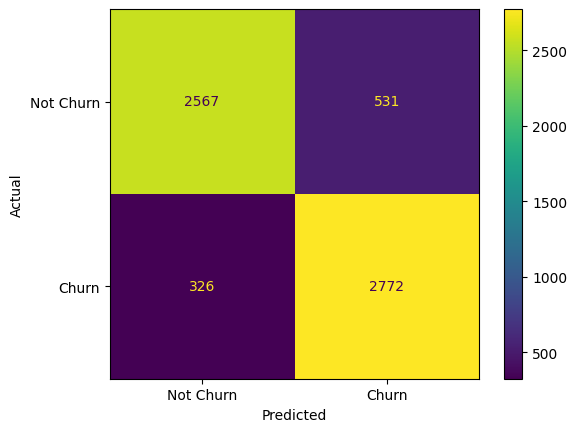

              precision    recall  f1-score   support

   Not Churn       0.89      0.83      0.86      3098
       Churn       0.84      0.89      0.87      3098

    accuracy                           0.86      6196
   macro avg       0.86      0.86      0.86      6196
weighted avg       0.86      0.86      0.86      6196



In [25]:
# visualise confusion matrix for knn set train
class_label = ['Not Churn', 'Churn']

print('K-Nearest Neighbors - Train Set')
cm = confusion_matrix(y_train_resample, y_pred_train_knn)
class_label = ['Not Churn', 'Churn']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_label)
disp.plot()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(classification_report(y_train_resample, y_pred_train_knn, target_names=class_label))

K-Nearest Neighbors - Test Set


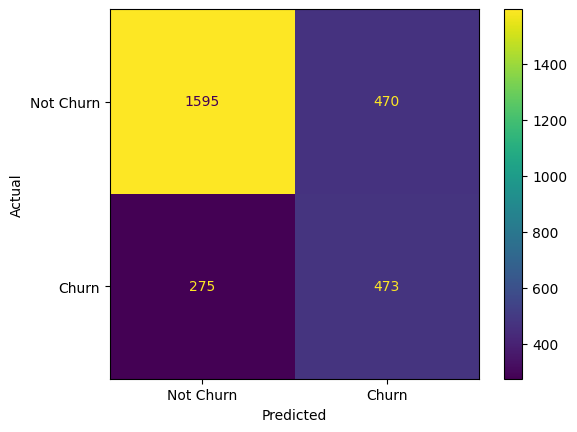

              precision    recall  f1-score   support

   Not Churn       0.85      0.77      0.81      2065
       Churn       0.50      0.63      0.56       748

    accuracy                           0.74      2813
   macro avg       0.68      0.70      0.69      2813
weighted avg       0.76      0.74      0.74      2813



In [26]:
# visualise confusion matrix for knn set test
print('K-Nearest Neighbors - Test Set')
cm = confusion_matrix(y_test, y_pred_test_knn)
class_label = ['Not Churn', 'Churn']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_label)
disp.plot()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(classification_report(y_test, y_pred_test_knn, target_names=class_label))

In [27]:
precision_knn = cross_val_score(model_knn,
                                X_train_resample,
                                y_train_resample,
                                cv = 2,
                                scoring = 'precision')

print('Precision Score - All - Cross Validation  : ', precision_knn)
print('Precision Score - Mean - Cross Validation : ', precision_knn.mean())
print('Precision Score - Std - Cross Validation  : ', precision_knn.std())
print('Precision Score - Range of Test-Set       : ', (precision_knn.mean() - precision_knn.std()) , '-', (precision_knn.mean() + precision_knn.std()))

Precision Score - All - Cross Validation  :  [0.76981919 0.77028509]
Precision Score - Mean - Cross Validation :  0.7700521405216798
Precision Score - Std - Cross Validation  :  0.000232947197618516
Precision Score - Range of Test-Set       :  0.7698191933240612 - 0.7702850877192984


Explanation:

Precision score from class not churn from train set is 0.89 and test set is 0.85. Model performing good based on the precision we got when predicting not churned customers based on the actual data of not churned customers.  The stability of the model is also important. We use weighted average precision and compare it to the precision score with cross-validation technique. The results show that the model is stable on test set with a weighted average score in the range of validation score. We can conclude that this model are categorise as goodfit.

#### 2. RFC Model Evaluation

Random Forest Classifier - Train Set


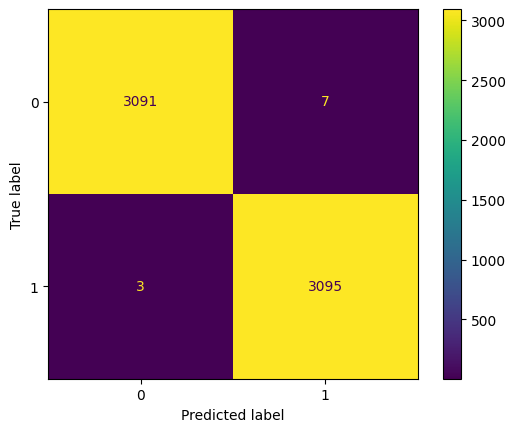

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3098
           1       1.00      1.00      1.00      3098

    accuracy                           1.00      6196
   macro avg       1.00      1.00      1.00      6196
weighted avg       1.00      1.00      1.00      6196



In [28]:
# visualise confusion matrix for rfc set train
print('Random Forest Classifier - Train Set')
cm = confusion_matrix(y_train_resample, y_pred_train_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()
print(classification_report(y_train_resample, y_pred_train_rfc))

Random Forest Classifier - Test Set


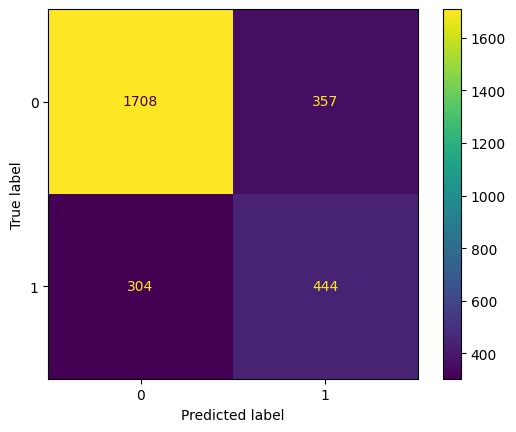

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2065
           1       0.55      0.59      0.57       748

    accuracy                           0.77      2813
   macro avg       0.70      0.71      0.71      2813
weighted avg       0.77      0.77      0.77      2813



In [29]:
# visualise confusion matrix for rfc set test
print('Random Forest Classifier - Test Set')
cm = confusion_matrix(y_test, y_pred_test_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_test_rfc))

In [30]:
precision_rfc = cross_val_score(model_rfc,
                                X_train_resample,
                                y_train_resample,
                                cv = 2,
                                scoring = 'precision')

print('Precision Score - All - Cross Validation  : ', precision_rfc)
print('Precision Score - Mean - Cross Validation : ', precision_rfc.mean())
print('Precision Score - Std - Cross Validation  : ', precision_rfc.std())
print('Precision Score - Range of Test-Set       : ', (precision_rfc.mean() - precision_rfc.std()) , '-', (precision_rfc.mean() + precision_rfc.std()))

Precision Score - All - Cross Validation  :  [0.83495146 0.79145587]
Precision Score - Mean - Cross Validation :  0.8132036651986225
Precision Score - Std - Cross Validation  :  0.021747791112057047
Precision Score - Range of Test-Set       :  0.7914558740865655 - 0.8349514563106796


Explanation:

The precision score from class not churn from the train set is 1.00 and the test set is 0.85. Model performing well based on the precision we got when predicting not churned customers based on the actual data of not churned customers. Still, we categorise this model as overfit, because the difference in precision score between the train set and test set is large.

The stability of the model is also important. We use weighted average precision and compare it to the precision score with cross cross-validation technique. The results show that there's a 0.01 difference outside the range of precision with cross-validation. The model shows stability on test results with a little difference to the validation score.

#### 3. XGB Model Evaluation

XGBoost Classifier - Train Set


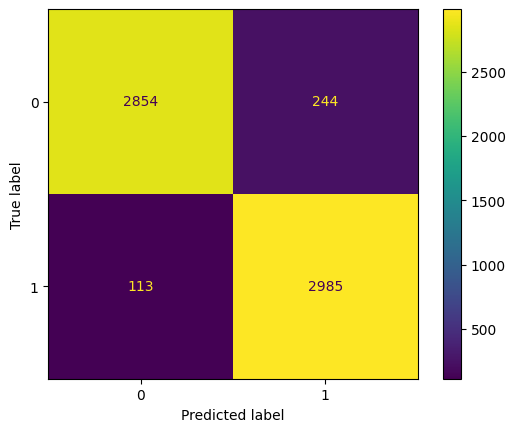

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3098
           1       0.92      0.96      0.94      3098

    accuracy                           0.94      6196
   macro avg       0.94      0.94      0.94      6196
weighted avg       0.94      0.94      0.94      6196



In [31]:
# visualise confusion matrix for xgb set train
print('XGBoost Classifier - Train Set')
cm = confusion_matrix(y_train_resample, y_pred_train_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()
print(classification_report(y_train_resample, y_pred_train_xgb))

XGBoost Classifier - Test Set


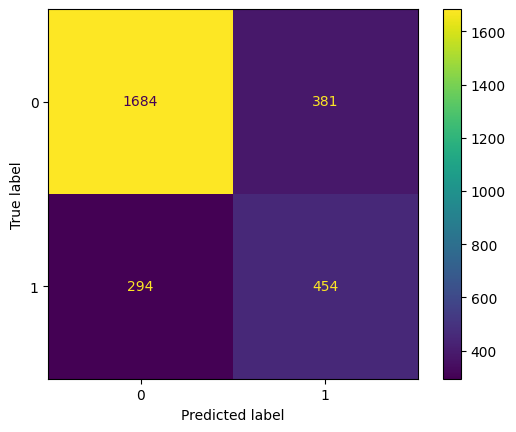

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      2065
           1       0.54      0.61      0.57       748

    accuracy                           0.76      2813
   macro avg       0.70      0.71      0.70      2813
weighted avg       0.77      0.76      0.76      2813



In [32]:
# visualise confusion matrix for xgb set test
print('XGBoost Classifier - Test Set')
cm = confusion_matrix(y_test, y_pred_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_test_xgb))

In [33]:
precision_boost = cross_val_score(model_boost,
                                X_train_resample,
                                y_train_resample,
                                cv = 2,
                                scoring = 'precision')

print('Precision Score - All - Cross Validation  : ', precision_boost)
print('Precision Score - Mean - Cross Validation : ', precision_boost.mean())
print('Precision Score - Std - Cross Validation  : ', precision_boost.std())
print('Precision Score - Range of Test-Set       : ', (precision_boost.mean() - precision_boost.std()) , '-', (precision_boost.mean() + precision_boost.std()))

Precision Score - All - Cross Validation  :  [0.82612056 0.79498364]
Precision Score - Mean - Cross Validation :  0.8105520993630531
Precision Score - Std - Cross Validation  :  0.01556845705116644
Precision Score - Range of Test-Set       :  0.7949836423118866 - 0.8261205564142196


Explanation:

The precision score from class not churn from the train set is 0.96 and the test set is 0.85. Model performing well based on the precision we got when predicting not churned customers based on the actual data of not churned customers. Still, we categorise this model as overfit, because the difference in precision score between the train set and test set is large.

The stability of the model is also important. We use weighted average precision and compare it to the precision score with cross cross-validation technique. The results show that there's a 0.01 difference outside the range of precision with cross-validation. The model shows stability on test results with a little difference to the validation score.

#### 4. Model Analysis and Decision

From all of the models that we compare, here's the advantage and disadvantage from the models we are used:

- K-Nearest Neighbors
    - Advantage of K-Nearest Neighbors model:
        - Simple to use when we are uses the model
        - There's no training step
        - Few parameter to set, because this models having only 2 parameter, number of neighbors and distance.
    - Disadvantage of K-Nearest Neighbors model:
        - Slow when handling larger data
        - Struggles with many features, so selection process for this model is important.
        - High tendency to overfit

- Random Forest        
    - Advantage of Random Forest model:
        - Providing high accuracy prediction with large datasets.
        - Doesn't require normalization or stardarization on dataset.
    - Disadvantage of Random Forest model:
        - Expensive in computation if we use a larger number of trees.

- XGBoost     
    - Advantage of XGBoost model:
        - Scalable and useful on large datasets
        - Doesn't require normalization or standarization on dataset.
    - Disadvantage of XGBoost model:
        - Expensive in computation if we use a larger number of trees.

Based on the model evaluation, the only model that categorises as a good fit is K-Nearest Neighbors model. All of our models performed well and can be used for predicting not churned customers. The caveat is two of the three models that we tested were categorised as overfit despite showing stability on validation score. If we use the overfit model, there's a chance that the result will be worse on other data. We can conclude that we gonna use the K-Nearest Neighbors for the hyperparameter tuning process. 

## III. Hyperparameter Tuning With Best Machine Learning Model

### A. Model Definition

#### 1. Finding Best Parameter

In [34]:
# determine parameter
grid_search_parameter = {
    'knn__n_neighbors' : [7, 9, 11, 13]
}

grid_search_parameter

{'knn__n_neighbors': [7, 9, 11, 13]}

In [35]:
# train with grid search
knn_gridcv = GridSearchCV(estimator=model_knn,
                         param_grid=grid_search_parameter,
                         cv=2,
                         n_jobs=1,
                         verbose=2,
                         scoring='precision')

knn_gridcv.fit(X_train_resample, y_train_resample)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END .................................knn__n_neighbors=7; total time=   0.0s
[CV] END .................................knn__n_neighbors=7; total time=   0.0s
[CV] END .................................knn__n_neighbors=9; total time=   0.0s
[CV] END .................................knn__n_neighbors=9; total time=   0.0s
[CV] END ................................knn__n_neighbors=11; total time=   0.0s
[CV] END ................................knn__n_neighbors=11; total time=   0.0s
[CV] END ................................knn__n_neighbors=13; total time=   0.0s
[CV] END ................................knn__n_neighbors=13; total time=   0.0s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprospipe',
                                        ColumnTransformer(transformers=[('pipe_num',
                                                                         Pipeline(steps=[('scaler_standard',
                                                                                          StandardScaler())]),
                                                                         ['tenure',
                                                                          'monthly_charges',
                                                                          'total_charges']),
                                                                        ('pipe_cat',
                                                                         Pipeline(steps=[('encode_oneshot',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'online_security',
                                                                          'contract',
                                                                          'paperless_billing',
                                                                          'payment_method'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=1, param_grid={'knn__n_neighbors': [7, 9, 11, 13]},
             scoring='precision', verbose=2)

In [36]:
knn_gridcv.best_params_

{'knn__n_neighbors': 7}

In [37]:
# create pipeline
knn_tuning = KNeighborsClassifier(n_neighbors=7)

best_model = Pipeline([('preprospipe', preprocess),
                       ('knn_tuning', knn_tuning)])

Explanation:

We use Grid Search technique to find the best parameter for our model. The parameter that we tune are n_neighbors parameter to adjust number of neighbors when the model want to predict the class. Result shown that the best value of n_neighbors is 7.

### B. Model Training

In [38]:
# model training process
best_model.fit(X_train_resample, y_train_resample)

Pipeline(steps=[('preprospipe',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('scaler_standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('encode_oneshot',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'online_security',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('knn_tuning', KNeighborsClassifier(n_neighbors=7))])

In [39]:
# predict with trained model
y_pred_train_best = best_model.predict(X_train_resample)
y_pred_test_best = best_model.predict(X_test)

### C. Model Evaluation

K-Nearest Neighbors - Train Set


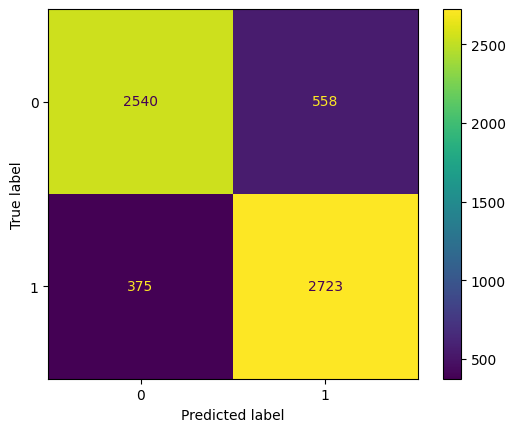

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      3098
           1       0.83      0.88      0.85      3098

    accuracy                           0.85      6196
   macro avg       0.85      0.85      0.85      6196
weighted avg       0.85      0.85      0.85      6196



In [40]:
# visualise confusion matrix for knn set train
print('K-Nearest Neighbors - Train Set')
cm = confusion_matrix(y_train_resample, y_pred_train_best)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()
print(classification_report(y_train_resample, y_pred_train_best))

K-Nearest Neighbors - Test Set


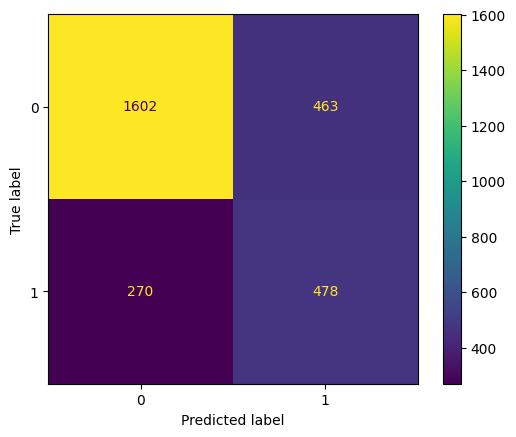

              precision    recall  f1-score   support

           0       0.86      0.78      0.81      2065
           1       0.51      0.64      0.57       748

    accuracy                           0.74      2813
   macro avg       0.68      0.71      0.69      2813
weighted avg       0.76      0.74      0.75      2813



In [41]:
# visualise confusion matrix for knn set test
print('K-Nearest Neighbors - Test Set')
cm = confusion_matrix(y_test, y_pred_test_best)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred_test_best))

In [42]:
precision_best = cross_val_score(best_model,
                                X_train_resample,
                                y_train_resample,
                                cv = 2,
                                scoring = 'precision')

print('Precision Score - All - Cross Validation  : ', precision_best)
print('Precision Score - Mean - Cross Validation : ', precision_best.mean())
print('Precision Score - Std - Cross Validation  : ', precision_best.std())
print('Precision Score - Range of Test-Set       : ', (precision_best.mean() - precision_best.std()) , '-', (precision_best.mean() + precision_best.std()))

Precision Score - All - Cross Validation  :  [0.76767677 0.77124183]
Precision Score - Mean - Cross Validation :  0.7694592988710636
Precision Score - Std - Cross Validation  :  0.0017825311942959443
Precision Score - Range of Test-Set       :  0.7676767676767676 - 0.7712418300653595


Explanation:

Based on the result above, the precision score on the train set decreased from 0.89 to 0.87, and on the test set it improved from 0.85 to 0.86. If we check the validation score, the precision weighted average from the model is in the range of validation score between 0.7676 and 0.7712. We can categorise this model as goodfit. Hyperparameter tuning that we do are successful because we have an improvement on our model on the test set score. 

[We will check the value of feature importancens to know what feature influences the most to the prediction. We use the permutation importance method from the Scikit-Learn library to find it. How the permutation importance method works by reshuffling value in one column and then predicting it. After that, the data will return to the original order, and repeat the step in the next column.](https://www.kaggle.com/code/dansbecker/permutation-importance)

In [43]:
# check feature importances
result = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=45)

In [44]:
# create dataframe for feature importances table
df_important = pd.DataFrame({
    'col_name': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# display feature importances table
df_important

,col_name,importance_mean,importance_std
13,monthly_charges,0.021958,0.005310
10,contract,0.014694,0.005361
8,online_security,0.013284,0.005397
4,tenure,0.009397,0.004991
3,dependents,0.006944,0.003477
11,paperless_billing,0.006920,0.004210
2,partner,0.006470,0.003728
12,payment_method,0.004112,0.004860
14,total_charges,0.004064,0.003738
0,gender,0.000000,0.000000


Explanation:

Based on the feature importances table, the top 5 features that influenced our churn prediction are customer monthly_charges, contract, online_security, tenure, and dependents column. Gender, phone_service, multiple_lines, internet_service, and streaming_tv columns have values equal to zero because they weren't included when we did the modelling process. Senior_citizen column have a negative importance mean value because it is not important when we do the modelling process, so it decreases the model performance. We will analyse the top 5 feature.

The number five feature that had importance when we did the modelling process is the dependents column. In the Exploratory Data Analysis section, the customers with no dependents have the tendency to churn. The number four feature is the tenure column. In the Exploratory Data Analysis section, the customers with shorter tenure have the tendency to churn, more than the customers with longer tenure. The number three feature is online security. In the Exploratory Data Analysis section, it just happens that customers who don't subscribe to our antivirus products are the most churned customers. The number two feature is contract. In the Exploratory Data Analysis section, the customers with the month-to-month contract are likely to churn, and there are a lot of customers complaining about auto-renewal contract terms. The number one feature is customers monthly charges. In the Exploratory Data Analysis section, the customers who are likely to churn are customers with higher monthly charges.

We can conclude that to reduce customer churn, we can pay attention to customer monthly charges, contract types, tenures, and having dependents or not, since it is in the top 5 of our feature importances table.

## IV. Model Saving

In [45]:
# saving model process
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# saving list of numerical columns
with open('num_cols.txt', 'w') as file_2:
  json.dump(num_cols, file_2)

# saving list of categorical columns
with open('cat_cols.txt', 'w') as file_3:
  json.dump(cat_cols, file_3)